In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier as KNN

from src.pipelines import get_wine_pipeline
from src.metrics import get_scores
from src.weights import log_distance

from configurations.knn_configurations import default_configuration, parameter_grid

In [2]:
dataset_title = "wine"

In [3]:
data = pd.read_pickle(f'../data/raw/{dataset_title}.pkl')

## Uruchomienie KNN

### Bez stratyfikacji

In [4]:
X, y = data.drop(columns=['class']), data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
pipeline = get_wine_pipeline()
pipeline.steps.append(['clf', KNN()])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

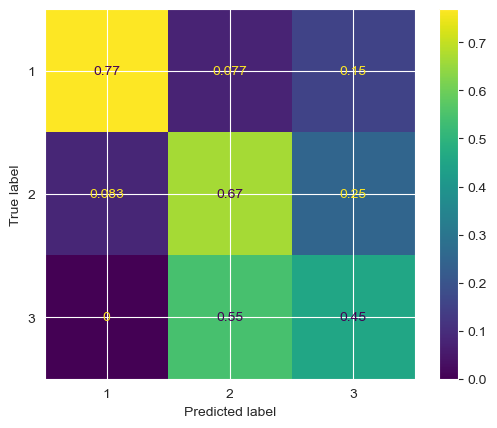

In [6]:
cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')
_ = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=pipeline.classes_,
).plot()
plt.savefig(f'../figures/{dataset_title}_cm.png')

In [7]:
get_scores(y_test, y_pred)

{'accuracy': 0.6389, 'precision': 0.6475, 'recall': 0.6301, 'f1': 0.634}

### Z stratyfikacją

In [8]:
X, y = data.drop(columns=['class']), data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [9]:
pipeline = get_wine_pipeline()
pipeline.steps.append(['clf', KNN()])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

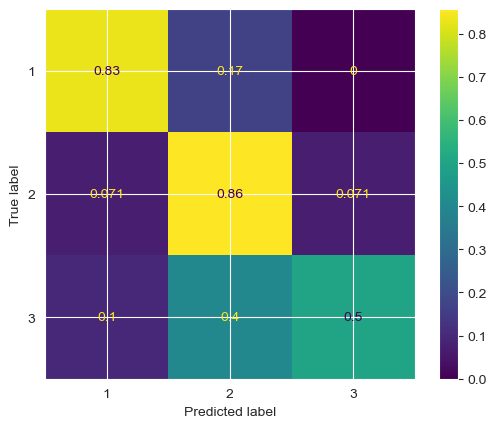

In [10]:
cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')
_ = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=pipeline.classes_,
).plot()
plt.savefig(f'../figures/{dataset_title}_cm.png')

In [11]:
get_scores(y_test, y_pred)

{'accuracy': 0.75, 'precision': 0.7778, 'recall': 0.7302, 'f1': 0.7361}

## Walidacja krzyżowa

### Bez stratyfikacji

In [12]:
folds = [2, 5, 10]

k_folds_test_log = {}
for k in folds:
    k_folds_test_log[k] = cross_validate(pipeline, X, y, cv=k, scoring='f1_macro')['test_score']

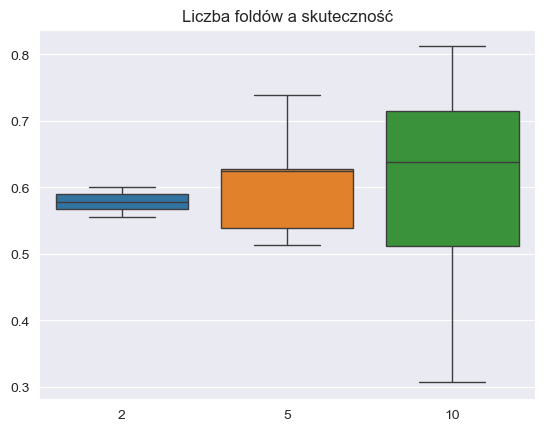

In [13]:
_ = sns.boxplot(k_folds_test_log)
_ = plt.title('Liczba foldów a skuteczność')

### Ze stratyfikacją

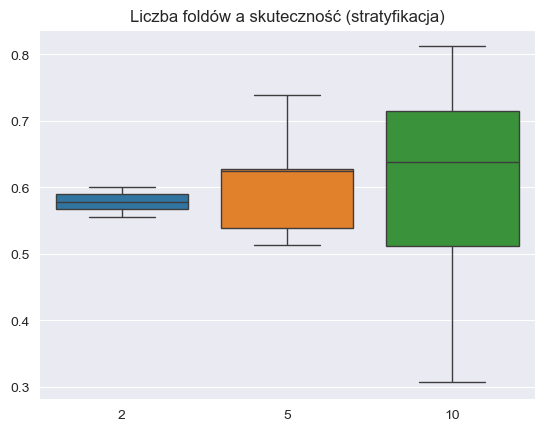

In [14]:
k_folds_test_log_str = {}

for k in folds:
    skf = StratifiedKFold(n_splits=k)
    k_folds_test_log_str[k] = cross_validate(pipeline, X, y, cv=skf, scoring='f1_macro')['test_score']
_ = sns.boxplot(k_folds_test_log_str)
_ = plt.title('Liczba foldów a skuteczność (stratyfikacja)')

## Sprawdzenie różnych wartości parametrów

In [15]:
search = GridSearchCV(pipeline, parameter_grid, cv=5, scoring='f1_macro')
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('normalizer', Normalizer()),
                                       ('pca',
                                        PCA(n_components=0.9,
                                            svd_solver='full')),
                                       ['clf', KNeighborsClassifier()]]),
             param_grid={'clf__metric': ['euclidean', 'manhattan', 'minkowski'],
                         'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15],
                         'clf__weights': ['uniform', 'distance',
                                          <function log_distance at 0x169c3f060>,
                                          <function robust_weights at 0x169c3f100>]},
             scoring='f1_macro')

In [16]:
search.best_params_

{'clf__metric': 'euclidean', 'clf__n_neighbors': 1, 'clf__weights': 'uniform'}

In [17]:
grid_search_results = pd.DataFrame(search.cv_results_)

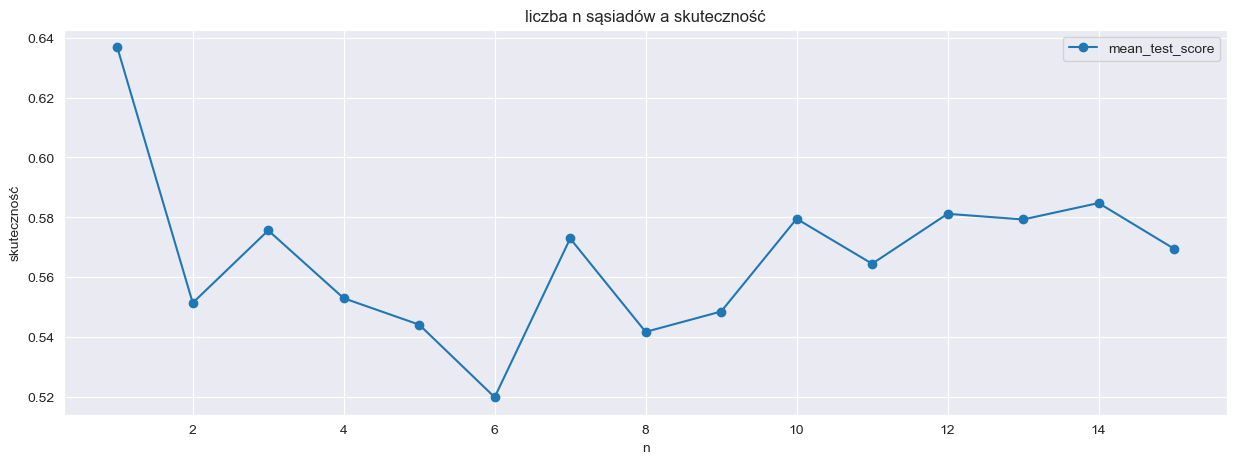

In [18]:
n_neighbors_stats = grid_search_results[(grid_search_results['param_clf__metric'] == default_configuration['clf__metric']) & (grid_search_results['param_clf__weights'] == default_configuration['clf__weights'])]

_ = n_neighbors_stats.plot(
    x='param_clf__n_neighbors',
    y=['mean_test_score'],
    figsize=(15, 5),
    grid=True,
    marker='o',
    xlabel='n',
    ylabel='skuteczność',
    title='liczba n sąsiadów a skuteczność',
)
plt.show()

In [19]:
weights_stats = grid_search_results[(grid_search_results['param_clf__metric'] == default_configuration['clf__metric']) & (grid_search_results['param_clf__n_neighbors'] == default_configuration['clf__n_neighbors'])]

weights_stats[['param_clf__weights', 'mean_test_score', 'std_test_score']]

,param_clf__weights,mean_test_score,std_test_score
136,uniform,0.544165,0.042411
137,distance,0.597049,0.090144
138,<function log_distance at 0x169c3f060>,0.165673,0.004300
139,<function robust_weights at 0x169c3f100>,0.555586,0.096419


In [20]:
weights_stats = grid_search_results[(grid_search_results['param_clf__weights'] == default_configuration['clf__weights']) & (grid_search_results['param_clf__n_neighbors'] == default_configuration['clf__n_neighbors'])]

weights_stats[['param_clf__metric', 'mean_test_score', 'std_test_score']]

,param_clf__metric,mean_test_score,std_test_score
16,euclidean,0.544165,0.042411
76,manhattan,0.544165,0.042411
136,minkowski,0.544165,0.042411
